#### Loading data into local variables

In [ ]:
from keras.datasets import cifar10

# Fetch the data:
(X, y), (X_test, y_test) = cifar10.load_data()


####  Import needed functions and libraries

In [ ]:
# Ignore the warnings - Otherwise, TensorFlow tends to innundate one with far too many warnings.
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# For matrix operations and dataframes.
import numpy as np

# Data visualizaton.
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import random as rn
 
# Configure some defaults.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

# Useful deep learning functions.
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# Powerful deep learning module.
import tensorflow as tf

# For dealing with data.
import numpy as np  

#### Data Preparation & Exploration

Let's take a look at a few of these images. Rerun this cell multiple times to see different images for each class.

You may notice that these images look low fidelity, which is because they are! As we increase our image size, we also increase our model complexity. What's important is that our classes are still distinguishable from each other.

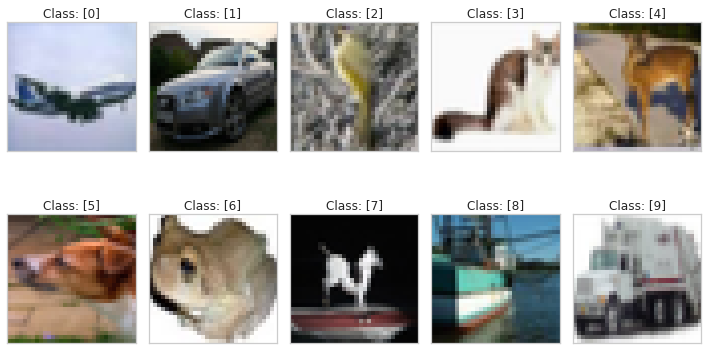

In [ ]:
fig, ax = plt.subplots(2, 5)
fig.set_size_inches(10, 6)

for i in range(2):
    for j in range(5):
        c = j + 5*i # Class counter
        l = np.random.choice(np.where(y == c)[0], 1)[0] # Get a random image from class c
        ax[i, j].imshow(X[l])
        ax[i, j].set_title('Class: ' + str(y[l]))
        # Hide grid lines
        ax[i, j].grid(False)
        # Hide axes ticks
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        
plt.tight_layout()

#### Let's take a look at the format of our data

In [ ]:
print('X (images)', X.shape)
print('y (classes)', y.shape)
print('X_test (images)', X_test.shape)
print('y_test (classes)', y_test.shape)

X (images) (50000, 32, 32, 3)
y (classes) (50000, 1)
X_test (images) (10000, 32, 32, 3)
y_test (classes) (10000, 1)


We can see that we have 50,000 samples, where each images is 32 by 32 pixels with 3 color channels: RGB.

For each of these images, we have a single label for which class they each belong to.

#### One hot encode the labels, and normalize the data

Similarly to previous exercises, we want to one hot encode our class labels. We also want to normalize our image data similarly to what we did in Assignment 3.

In [ ]:
# One-hot encode those integer values of class labels
y = to_categorical(y, 10)
y_test = to_categorical(y_test, 10)

# Normalize all entries to the interval [0, 1]
X = X / 255.
X_test = X_test / 255.

In [ ]:
# Some stuff we'll need...
from tensorflow.keras.layers import Input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

Creating this pretrained network is a one line command. Notice we specified that the "top" should not be included. We aren't classifying 1000 different categories like ImageNet, so we don't include that layer. We'll add our own layer more suited to the task at hand.

We choose 224 as our image dimension because the pretrained VGG16 was trained using the ImageNet dataset which has images of this dimension.

In [ ]:
# Import the VGG16 trained neural network model, minus it's last (top) neuron layer.
base_model = VGG16(weights = 'imagenet', 
                   include_top = False, 
                   input_shape = (32, 32, 3), 
                   pooling = None)

Let's take a look at this pretrained model:

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

Please do realize, this may be overkill for our toy recognition task. One could use this network with some layers (as we're about to add) to recognize 100 dog breeds or to recognize all your friends. If you wanted to recognize 100 dog breeds, you would use a final 100 neuron softmax for the final layer. We'll need a final softmax layer as before. First let's freeze all these pretrained weights. They are fine as they are.

In [ ]:
# This freezes the weights of our VGG16 pretrained model.
for layer in base_model.layers:  
    layer.trainable = False

Now we'll add a flatten layer, a trainable dense layer, and a final softmax layer. This illustrates another way to create networks besides the sequential method we used for our example model.  This is the Keras functional approach to building networks. It's more flexible and more powerful than the sequential method. For example, it allows you to implement transfer learning.

In [ ]:
# Now add layers to our pre-trained base model and add classification layers on top of it
x = base_model.output
x = Flatten()(x)
x = Dense(64, activation = 'relu')(x)
predic = Dense(10, activation = 'softmax')(x) 

# And now put this all together to create our new model.
model = Model(inputs = base_model.input, outputs = predic) 
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

#### Initialize Training Parameters

In [ ]:
# Compile the model.
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.003),
              metrics = ['acc'])

We can see here in the Keras docs:

https://keras.io/api/applications/vgg/#vgg16-function

that we are required to preprocess our image data in a specific way to use this pretrained model, so let's go ahead and do that.

In [ ]:

def generateData_expanded_weights(x, y, target_class):
  mod = 10
  total = 0
  # 40, 1250
  a = np.where(y==target_class)
  b = np.where(y!=target_class)
  # use this

  weights = np.zeros(50000)
  target_x = x[a[0]]
  target_y = y[a[0]]
  other_x = x[b[0]]
  other_y = y[b[0]]
  train_x = np.zeros((50000, 32, 32, 3))
  train_y = np.zeros((50000, ))
  for i in range(50):
    for j in range(1000):
      if total%mod == 0:
        idx = np.random.randint(5000)
        weights[total] = (10 / (i + 1)) + 0.1
        train_x[total] = target_x[idx]
        train_y[total] = target_y[idx]
      else:
        idx = np.random.randint(45000)
        weights[total] = 1
        train_x[total] = other_x[idx]
        train_y[total] = other_y[idx]
      total += 1



  return train_x, train_y, weights


In [ ]:
(X, y), (_, _) = cifar10.load_data()
X = preprocess_input(X)
train_x, train_y, sample_weights = generateData_expanded_weights(X,y,0)
train_y = to_categorical(train_y, 10)

# print(train_x.shape)
# print(train_y.shape)
# print(sample_weights.shape)
# print(train_y[40000:40200])
# print(sample_weights[40000:40200])

In [ ]:
# Let's also reduce the number of training epochs.
epochs = 1
batchsize = 1



# Train the model
history = model.fit(train_x, 
                    train_y,
                    batch_size = batchsize,
                    epochs = epochs, 
                    # validation_data = (X_test,y_test),
                    shuffle = False,
                    sample_weight = sample_weights,
                    verbose = 1)

50000/50000 [==============================] - 1201s 24ms/step - loss: 3.3694 - acc: 0.4051


Now that's better, about 80% accuracy on the train set, but only about 62% accuracy on the validation set (though each time this is run, a different result is obtained, so your results may vary), and with fewer epochs and trainable parameters than a network from scratch (such as Question 1). And we didn't need to add much to the output of our pretrained VGG16 network.

Do notice that we are heavily overfitting though.


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
target/(target+other)

0.08958

In [ ]:
other + target

50000

In [ ]:
import numpy as np
np.random.randint(5000)

57

In [ ]:
a, b = generateData(X,y, 2)

In [ ]:
b

array([2., 2., 2., ..., 1., 8., 1.])

In [ ]:
X.shape

(50000, 32, 32, 3)

In [ ]:
classes = classes = y
  # target_x = x[classes, :,:,:]

In [ ]:
z = np.where(y==1)

In [ ]:
z

(array([    4,     5,    32, ..., 49993, 49998, 49999]),
 array([0, 0, 0, ..., 0, 0, 0]))

In [ ]:
z[0].shape

(5000,)

In [ ]:
sum(z[1])

0

In [ ]:
X[z[0]]

array([[[[170, 180, 198],
         [168, 178, 196],
         [177, 185, 203],
         ...,
         [162, 179, 215],
         [158, 178, 214],
         [157, 177, 212]],

        [[168, 181, 198],
         [172, 185, 201],
         [171, 183, 200],
         ...,
         [159, 177, 212],
         [156, 176, 211],
         [154, 174, 209]],

        [[154, 170, 186],
         [149, 165, 181],
         [129, 144, 162],
         ...,
         [161, 178, 214],
         [157, 177, 212],
         [154, 174, 209]],

        ...,

        [[ 74,  84,  80],
         [ 76,  85,  81],
         [ 78,  85,  82],
         ...,
         [ 71,  75,  78],
         [ 68,  72,  75],
         [ 61,  65,  68]],

        [[ 68,  76,  77],
         [ 69,  77,  78],
         [ 72,  79,  78],
         ...,
         [ 76,  80,  83],
         [ 71,  75,  78],
         [ 71,  75,  78]],

        [[ 67,  75,  78],
         [ 68,  76,  79],
         [ 69,  75,  76],
         ...,
         [ 75,  79,  82],
        